# **Stock Exhange Predictions with LSTM**

### Imports

In [1]:
import os
import sys
import math
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Activation
from tensorflow.keras.layers import LSTM , GRU
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

### Exploratory Data Analysis

In [2]:
data = pd.read_csv('prices.csv')

In [3]:
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [5]:
data.dtypes

date      object 
symbol    object 
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

In [6]:
data.describe(include='all')

,date,symbol,open,close,low,high,volume
count,851264,851264,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
unique,3524,501,NaN,NaN,NaN,NaN,NaN
top,2016-05-31,FOX,NaN,NaN,NaN,NaN,NaN
freq,498,1762,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,NaN,NaN,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,NaN,NaN,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,NaN,NaN,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,NaN,NaN,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,NaN,NaN,79.879997,79.889999,79.110001,80.610001,5.222500e+06


In [7]:
date = pd.to_datetime(data['date'])
min(date), max(date)

(Timestamp('2010-01-04 00:00:00'), Timestamp('2016-12-30 00:00:00'))

In [8]:
data.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [9]:
data.symbol.unique()[0:20]

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN'], dtype=object)

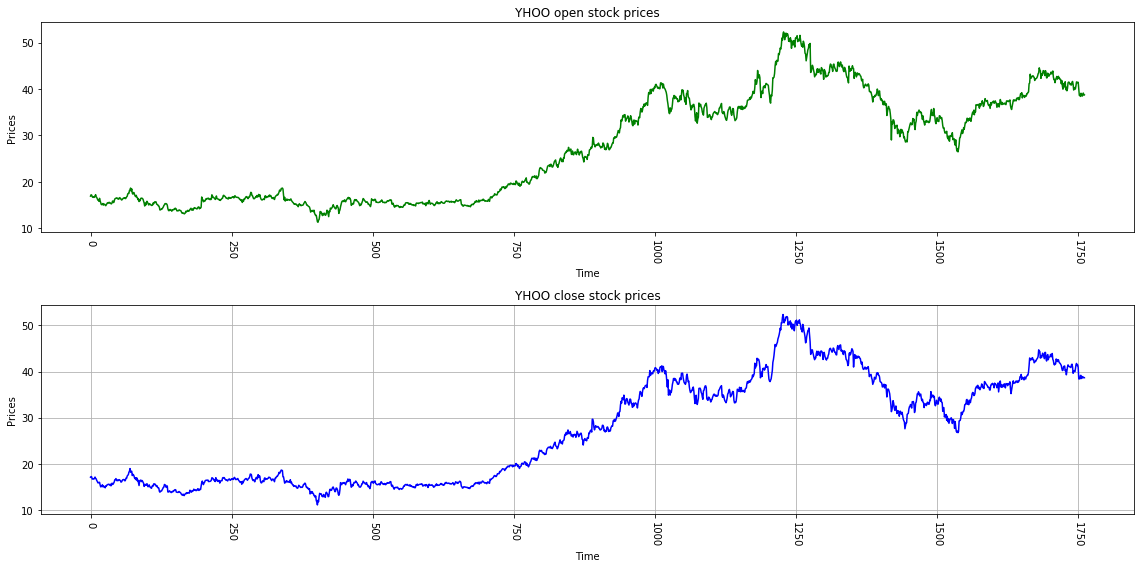

correlation: 0.9992


In [10]:
def plotter(df, symbol):
    company = df[df['symbol'] == symbol]
    open_values = company.open.values.astype('float32').reshape(-1, 1)
    close_values = company.close.values.astype('float32').reshape(-1, 1)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Prices')
    axes[0].set_title(symbol + ' open stock prices')
    axes[0].plot(open_values , 'g')
    axes[0].xaxis.set_tick_params(rotation=270)
    

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Prices')
    axes[1].set_title(symbol + ' close stock prices')
    axes[1].plot(close_values , 'b')
    axes[1].xaxis.set_tick_params(rotation=270)
    
    fig.tight_layout()
    plt.grid(True)
    plt.show()

symbol = 'YHOO'
plotter(data, symbol)

symbol_df = data.loc[data['symbol'] == symbol]
print(f"correlation: {np.around(symbol_df[['open', 'close']].corr().values[0, 1], 4)}")

### Preprocessing

In [11]:
series = data.loc[data['symbol'] == symbol, ['close']]
series_mean = series.mean().values.item()
series = series - series_mean
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

In [12]:
pd.DataFrame(series).describe()

,0
count,1762.000000
mean,0.392490
std,0.276329
min,0.000000
25%,0.117006
50%,0.379360
75%,0.636810
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E81068CF8>]],
      dtype=object)

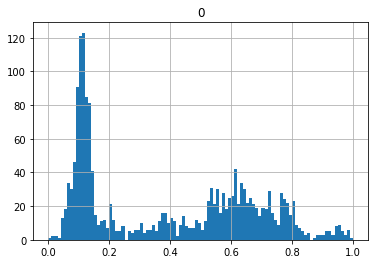

In [13]:
pd.DataFrame(series).hist(bins=100)

### Modeling

In [14]:
# Split dataset into train and test
train_length = int(len(series) * 0.8)
train = series[:train_length]
test = series[train_length:]
train.shape, test.shape

((1409, 1), (353, 1))

In [22]:
def process_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data) - n_steps):
        sequence = data[i : (i + n_steps), 0]
        X.append(sequence)
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

In [1]:
n_steps = 2
X_train, y_train = process_data(train, n_steps)
X_test, y_test = process_data(test, n_steps)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

NameError: name 'process_data' is not defined

In [17]:
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

In [18]:
filepath = './model.h5'
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_delta=0.0001, patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [19]:
model = Sequential()
model.add(GRU(256 , input_shape=(n_steps, 1) , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(32 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 256)            198912    
_________________________________________________________________
dropout (Dropout)            (None, 2, 256)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [20]:
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.0001) , metrics = ['mean_squared_error'])

In [21]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=256, 
                    callbacks=[checkpoint, lr_reduce], 
                    validation_data=(X_test, y_test))

Train on 1407 samples, validate on 351 samples
Epoch 1/100
1280/1407 [==========================>...] - ETA: 0s - loss: 0.1789 - mean_squared_error: 0.1789
Epoch 00001: val_loss improved from inf to 0.32544, saving model to ./model.h5
1407/1407 [==============================] - 5s 4ms/sample - loss: 0.1801 - mean_squared_error: 0.1801 - val_loss: 0.3254 - val_mean_squared_error: 0.3254
Epoch 2/100
1280/1407 [==========================>...] - ETA: 0s - loss: 0.1582 - mean_squared_error: 0.1582
Epoch 00002: val_loss improved from 0.32544 to 0.28733, saving model to ./model.h5
1407/1407 [==============================] - 0s 266us/sample - loss: 0.1562 - mean_squared_error: 0.1562 - val_loss: 0.2873 - val_mean_squared_error: 0.2873
Epoch 3/100
1280/1407 [==========================>...] - ETA: 0s - loss: 0.1378 - mean_squared_error: 0.1378
Epoch 00003: val_loss improved from 0.28733 to 0.24615, saving model to ./model.h5
1407/1407 [==============================] - 0s 286us/sample - loss: 

Epoch 25/100
1280/1407 [==========================>...] - ETA: 0s - loss: 7.3835e-04 - mean_squared_error: 7.3835e-04
Epoch 00025: val_loss did not improve from 0.00041
1407/1407 [==============================] - 0s 170us/sample - loss: 7.4958e-04 - mean_squared_error: 7.4958e-04 - val_loss: 7.0808e-04 - val_mean_squared_error: 7.0808e-04
Epoch 26/100
1280/1407 [==========================>...] - ETA: 0s - loss: 7.3649e-04 - mean_squared_error: 7.3649e-04
Epoch 00026: val_loss did not improve from 0.00041
1407/1407 [==============================] - 0s 169us/sample - loss: 7.3057e-04 - mean_squared_error: 7.3057e-04 - val_loss: 8.9828e-04 - val_mean_squared_error: 8.9828e-04
Epoch 27/100
1280/1407 [==========================>...] - ETA: 0s - loss: 8.5085e-04 - mean_squared_error: 8.5085e-04
Epoch 00027: val_loss did not improve from 0.00041

Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
1407/1407 [==============================] - 0s 173us/sample - los

1280/1407 [==========================>...] - ETA: 0s - loss: 5.7532e-04 - mean_squared_error: 5.7532e-04
Epoch 00071: val_loss did not improve from 0.00038
1407/1407 [==============================] - 0s 178us/sample - loss: 5.8424e-04 - mean_squared_error: 5.8424e-04 - val_loss: 3.8871e-04 - val_mean_squared_error: 3.8871e-04
Epoch 72/100
1280/1407 [==========================>...] - ETA: 0s - loss: 6.5859e-04 - mean_squared_error: 6.5859e-04
Epoch 00072: val_loss improved from 0.00038 to 0.00038, saving model to ./model.h5
1407/1407 [==============================] - 0s 296us/sample - loss: 6.4109e-04 - mean_squared_error: 6.4109e-04 - val_loss: 3.8180e-04 - val_mean_squared_error: 3.8180e-04
Epoch 73/100
1280/1407 [==========================>...] - ETA: 0s - loss: 6.2750e-04 - mean_squared_error: 6.2750e-04
Epoch 00073: val_loss did not improve from 0.00038
1407/1407 [==============================] - 0s 179us/sample - loss: 6.4511e-04 - mean_squared_error: 6.4511e-04 - val_loss: 3.9

In [23]:
# Load best model
model = load_model(filepath)

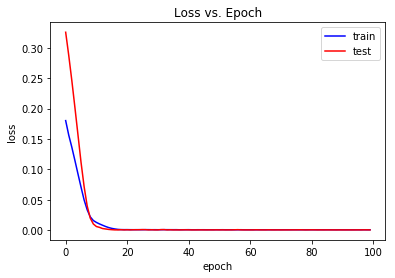

In [24]:
# Plot loss vs epoch
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
plt.title('Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [25]:
def model_score(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (train_score[0], math.sqrt(train_score[0])))
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

model_score(model, X_train, y_train , X_test, y_test)

Train Score: 0.00024 MSE (0.02 RMSE)
Test Score: 0.00038 MSE (0.02 RMSE)


In [26]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred) + series_mean

In [27]:
y_test = y_test[..., np.newaxis]
y_test = scaler.inverse_transform(y_test) + series_mean

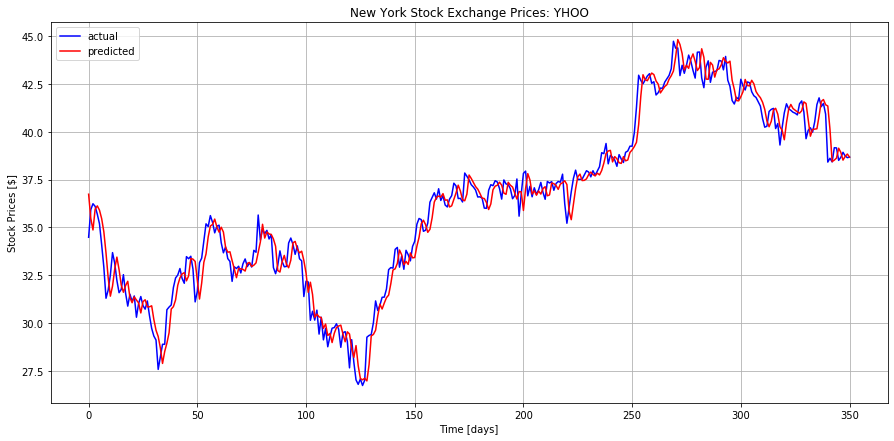

In [29]:
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(y_test, label='actual', color='b')
plt.plot(pred, label='predicted', color='r')
plt.xlabel('Time [days]')
plt.ylabel('Stock Prices [$]')
plt.title('New York Stock Exchange Prices: YHOO')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()